# Scraping euromomo data from the graphs

>EuroMOMO is a European mortality monitoring activity, aiming to detect and measure excess deaths related to seasonal influenza, pandemics and other public health threats.

>Official national mortality statistics are provided weekly from the 24 European countries in the EuroMOMO collaborative network, supported by the European Centre for Disease Prevention and Control (ECDC) and the World Health Organization (WHO).

## Graph data

They have data but it's not easy to access using normal means.

- they have repo with their model on [github](https://github.com/EuroMOMOnetwork/MOMO)
- it can be done using this  [pixel-scraper](https://github.com/browserdotsys/euromomo)


### But

1. I wanted the **raw** data for the graphs. 
1. The graphs are rendered dynamically using the **amazing** [Gatsby](https://www.gatsbyjs.org/).
1. This means you can't just dump the page source and scrape the data as text.


I'll got what I wanted by running a  [script](https://github.com/macbuse/COVID_stats/blob/master/ep.js)

```node ep.js```

You'll need to install [puppeteer](https://github.com/puppeteer/puppeteer) and have **node > 10.*** to do this.

The script **ep.js** emulates a user browsing the page - scrolling up and down to the graphs thus fooling the browser into executing all the **javascript** in the page and rendering the graphs. 


---

## What we are after: Z-score

This is the official [definition](https://www.euromomo.eu/how-it-works/what-is-a-z-score/)

In general, 

$ \text{Z-score} = \frac{(x-\text{mean of the population})}{(\text{Standard deviation of the population})}$

which could be approximated in our context by 

$ \text{S-score} = \frac{(\text{number of deaths - baseline})}{(\text{Standard deviation of residuals})}$

(variation of the number of deaths around the baseline) on the part of the series used to fit the model, used as the standard unit.

In [1]:
import pandas as pd

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
cd /home/gregmcshane/CHROME

/home/gregmcshane/CHROME


##originally...

I wanted to do this with [pyppeteer](https://github.com/miyakogi/pyppeteer)
but I ended up using javascript because I could just copy paste code from
the console in **Chrome's developer panel**.

The script dumps the **innerHtml** from each graph to a file **./graph*.html**
then I scrape the data using **regexp**.


```
re.compile('<h4>(.*?)<')      #country name
re.compile('[M|L]\d+,(\d+)')  #the path data
```



In [4]:
import re
cn = re.compile('<h4>(.*?)<')
pp = re.compile('[M|L]\d+,(\d+)')

graphs = {}

for k in range(1,25):
    with open('graph%d.html'%k, 'r') as fp:
        svg = fp.read()
    X = np.array([ int(x) for x in pp.findall(svg)])
    #I had to figure this out from the graphs
    #it actually changes depending on what age cat. you choose
    graphs[cn.search(svg).group(1)] =  X

# converting raw data

The curve data is a list of y-values as integers.
I need to rescale it to get to their **z-scores**.

In [5]:
from scipy import stats

X = min(graphs['Netherlands']), min(graphs['France']), min(graphs['UK (England)'])
Y = (10.13, 21.63, 42.34)
vv = stats.linregress( X, Y)


In [6]:
vv.slope, - 40/(80 - 7), vv.intercept,  80* 40/(80 - 7)

(-0.784248120300752, -0.547945205479452, 48.22744360902256, 43.83561643835616)

In [7]:
if False:
    for kk in graphs.keys():
        graphs[kk] = vv.slope * graphs[kk] +  vv.intercept
else:
    for kk in graphs.keys():
        graphs[kk] = (80 - graphs[kk]) * 40/(80 - 7)
     

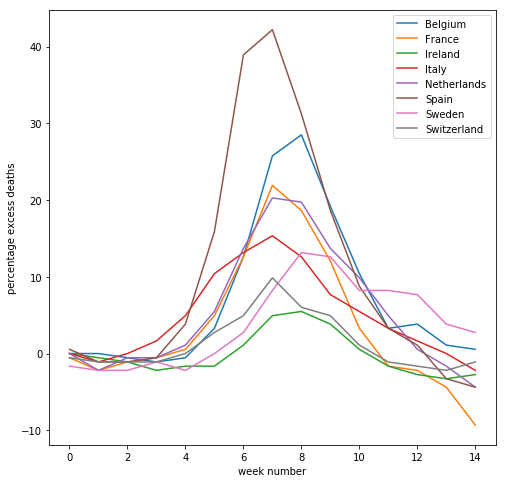

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)

for kk in graphs.keys():
    if 'UK' in kk: continue
    dd = graphs[kk][-15:]
    if max(dd) < 5: continue
    plt.plot(dd, label=kk)
    
plt.ylabel('percentage excess deaths')
plt.xlabel('week number')
leg = ax.legend()

# Comparing just 2 countries

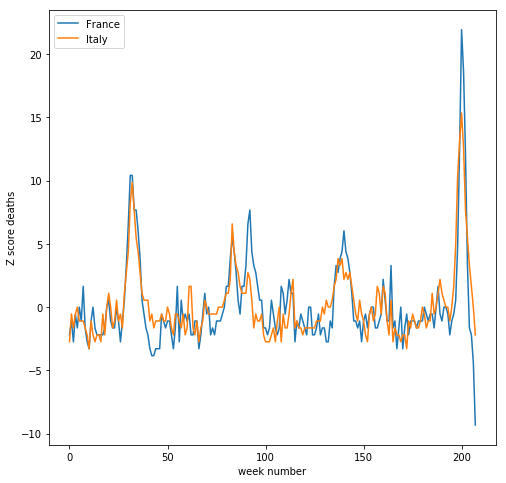

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)

for kk in ['France', 
           #'UK (England)',
           'Italy'
           #'Netherlands'
          ]:
    
    dd = graphs[kk][:]
    if max(dd) < 5: continue
    plt.plot(dd, label=kk)
    #plt.plot((1 + dd/100)*1800*7, label=kk)
    
plt.ylabel('Z score deaths')
plt.xlabel('week number')
leg = ax.legend()

22.465753424657542
46.575342465753415
12.602739726027394
47.67123287671233


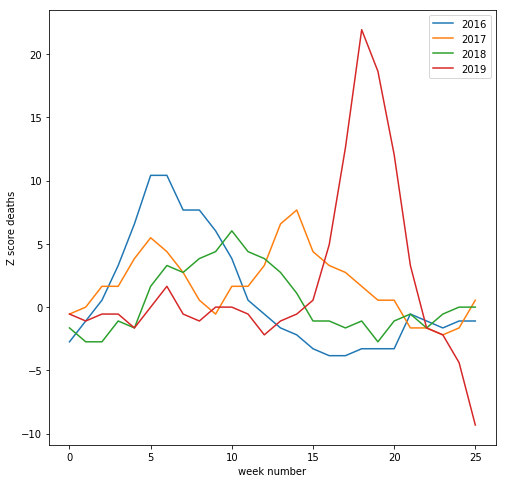

In [10]:

#they count the flu season as starting the previous year
labels = [str(2016 + k) for k in range(5)]


fig, ax = plt.subplots()
fig.set_size_inches(8,8)

FF = graphs['France']
uu = len(FF)
for k in [0,1,2,3]:
    tt = FF[52*k + 26 :52*k + 52]
    plt.plot(tt, label=labels[k] )
    print(sum(tt))
    
plt.ylabel('Z score deaths')
plt.xlabel('week number')
leg = ax.legend()

In [11]:
3*sum(graphs['France'][-12:]*1500/100)*7

17605.4794520548

# Comparing with raw data from INSEE

>During the Covid-19 pandemic, INSEE is reporting the number of deaths per day per department on a weekly basis. Deaths are recorded in the commune in which they occur (and not in the place of residence of the deceased). The statistics released are provisional (please see the methodological note (in French)). The CSV file containing the (non-personal) data regarding each death is also updated weekly.


They give away data [here](https://www.insee.fr/fr/statistiques/4487988?sommaire=4487854).
I think I manually downloaded this but I should it.


<script id="gatsby-script-loader">/*<![CDATA[*/window.pagePath="/graphs-and-maps";/*]]>*/</script>

In [12]:
df = pd.read_csv('2020-05-22_deces_quotidiens_departement_csv.csv', sep=';')
df[:3]

,Date_evenement,Zone,Communes_a_envoi_dematerialise_Deces2020,Total_deces_2020,Communes_a_envoi_dematerialise_Deces2019,Total_deces_2019,Communes_a_envoi_dematerialise_Deces2018,Total_deces_2018
0,01-mars,France,1625.0,1777.0,1708,1872,1928,2136
1,02-mars,France,3263.0,3556.0,3467,3782,3933,4327
2,03-mars,France,4891.0,5317.0,5035,5530,5881,6455


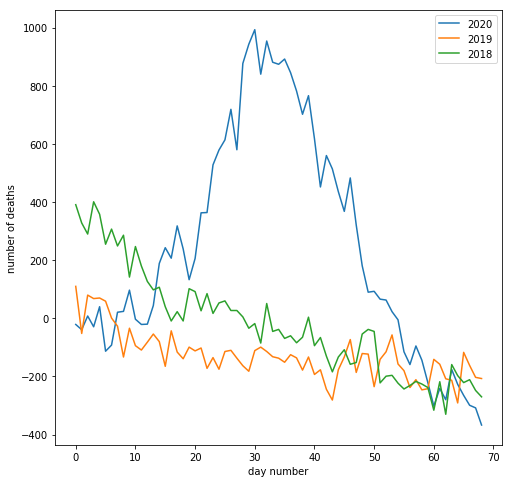

In [13]:
labels = [str(2018 + k) for k in range(3)]


fig, ax = plt.subplots()
fig.set_size_inches(8,8)


for k in [3,5,7]:
    XX = df.iloc[:70,k]
    plt.plot(np.diff(XX) - 1800, label=labels.pop())
    
plt.ylabel('number of deaths')
plt.xlabel('day number')
leg = ax.legend()

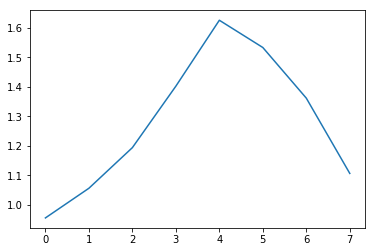

In [20]:
XX = np.diff( df.iloc[:70,3]) / np.diff( df.iloc[:70,5]) #compare days from 2020 and 2019
CX = np.convolve(XX, np.ones((7,))/7, mode='valid')  #rolling average

plt.plot( [CX[7*k] for k in np.arange(8)]) #plot a sample - every 7th day

# Z-score

This is the official [definition](https://www.euromomo.eu/how-it-works/what-is-a-z-score/)

In general, 

$ \text{Z-score} = \frac{(x-\text{mean of the population})}{(\text{Standard deviation of the population})}$

which could be approximated in our context by 

$ \text{S-score} = \frac{(\text{number of deaths - baseline})}{(\text{Standard deviation of residuals})}$

(variation of the number of deaths around the baseline) on the part of the series used to fit the model, used as the standard unit.

---

I'll plot their S-score for France and fit the data from the INSEE by hand.

- I think this means that they are claiming a SD of .333 for the data for France
- I could do a better fit using least squares 

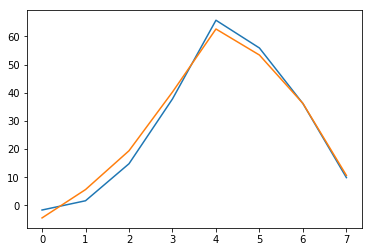

In [17]:
plt.plot( 3*graphs['France'][-12:-4]) # shouldn't hard code this range - 
plt.plot( [100*(CX[7*k] - 1) for k in np.arange(8)])

In [126]:

610000/365

1671.2328767123288